# Spotted star

This is a simple example of how one might go about modeling rotational light curves of spotted stars.

In [15]:
import starry
import numpy as np
import matplotlib.pyplot as pl
from tqdm import tqdm

In [2]:
%matplotlib inline

## Creating a map with a starspot

Let's create a 30th order map with a starspot at latitude 30$^\circ$ N and longitude 30$^\circ$ E:

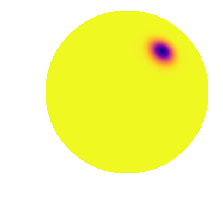

In [27]:
star = starry.Map(30)
star[0,0] = 1
star.add_gaussian(sigma=0.1, amp=-1, lat=30 * np.pi / 180, lon=30 * np.pi / 180)
star.show()

We can add additional spots to the map if we'd like:

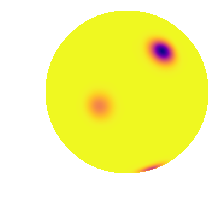

In [28]:
star.add_gaussian(sigma=0.1, amp=-0.3, lat=-10 * np.pi / 180, lon=-20 * np.pi / 180)
star.add_gaussian(sigma=0.1, amp=-0.5, lat=-70 * np.pi / 180, lon=60 * np.pi / 180)
star.show()

If stars didn't rotate differentially, computing this star's rotational light curve would be cake. Let's give it a rotation period of 1 day and see what it looks like:

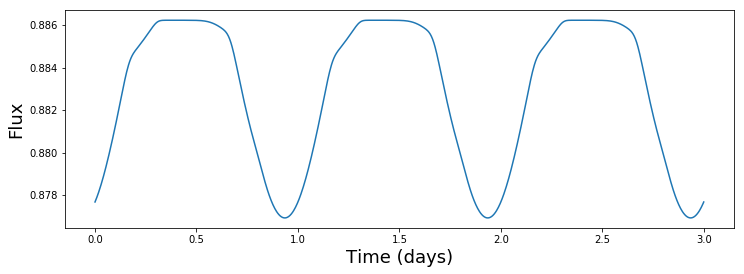

In [31]:
time = np.linspace(0, 3, 1000)
P = 1.
theta = 2 * np.pi / P * time
flux = star.flux(axis=(0, 1, 0), theta=theta)
fig, ax = pl.subplots(1, figsize=(12, 4))
pl.plot(time, flux)
pl.xlabel('Time (days)', fontsize=18);
pl.ylabel('Flux', fontsize=18);

## Differential rotation

In reality, starspots at different latitudes should rotate at different rates. We can simulate this by generating different `starry` maps for each starspot, and adding the light curves together.

Let's generate a few spots of random sizes, amplitudes, and location on the star.

In [3]:
nspots = 5
sigma = [0.1, 0.1, 0.2, 0.3, 0.1]
amp = [-0.1, -0.2, -0.01, -0.05, -0.1]
lat = np.array([0, 30, -20, 45, -60]) * np.pi / 180
lon = np.array([30, 60, 120, -30, -45]) * np.pi / 180
spot = [starry.Map(30) for n in range(nspots)]
for n in range(nspots):
    spot[n].add_gaussian(sigma=sigma[n], amp=amp[n], lat=lat[n], lon=lon[n])

We can visualize what the star looks like at time $t = 0$ by adding the maps:

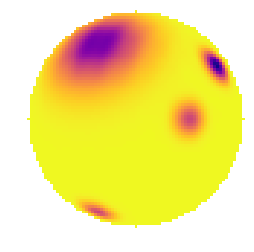

In [40]:
x, y = np.meshgrid(np.linspace(-1, 1, 75), np.linspace(-1, 1, 75))
img = np.zeros_like(x)
for n in range(nspots):
    img += np.array([spot[n].evaluate(x=x[j], y=y[j]) for j in range(75)])
pl.imshow(img, cmap='plasma', origin='lower');
pl.gca().axis('off');

That's a crazy looking star. For simplicity, let's give each of the spots a rotation period proportional to the latitude:

In [5]:
P = 1 + np.abs(lat)
print(P)

[1.         1.52359878 1.34906585 1.78539816 2.04719755]


Let's compute the light curve over the span of 10 days:

100%|██████████| 16/16 [00:01<00:00,  8.64it/s]


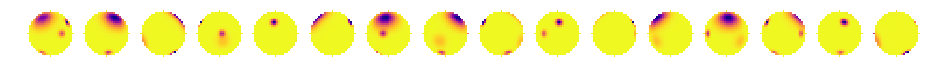

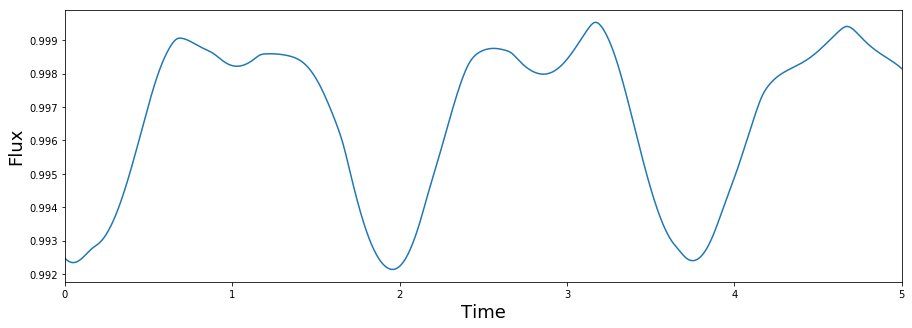

In [38]:
# The angular position of the spots over time
time = np.linspace(0, 5, 1000)
theta = [2 * np.pi / P[n] * time for n in range(nspots)]

# Plot the map
nimg = 16
res = 25
fig, ax = pl.subplots(1, nimg, figsize=(nimg, 1))
x, y = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))
for k, i in tqdm(enumerate(np.linspace(0, 1000, nimg, endpoint=False)), total=16):
    img = np.zeros_like(x)
    for n in range(nspots):
        img += np.array([spot[n].evaluate(theta=theta[n][int(i)], x=x[j], y=y[j]) for j in range(res)])
    img -= np.nanmin(img)
    img /= np.nanmax(img)
    ax[k].imshow(img, cmap='plasma', origin='lower', vmax=1., vmin=0.);
    ax[k].axis('off');

# Plot the combined light curve
lc = 1 + np.sum([spot[n].flux(axis=(0,1,0), theta=theta[n]) for n in range(nspots)], axis=0)
fig, ax = pl.subplots(1, figsize=(15, 5))
ax.plot(time, lc);
ax.set_xlim(0,5)
ax.set_ylabel("Flux", fontsize=18);
ax.set_xlabel("Time", fontsize=18);